In [4]:
def get_images_labels_list(images_dir_path):
    """
    Recursively iterates through a directory and its subdirectories to list the info all the images found in it.
    Returns a list of dictionary where each dictionary contains `image_path` and `image_label`.
    """
    images_labels_list = []
    for (dirpath, dirnames, filenames) in walk(images_dir_path):
        for filename in filenames:
            image_path = join(dirpath, filename)
            image_label = splitext(basename(dirpath))[0]
            image_info = {}
            image_info['image_path'] = image_path
            image_info['image_label'] = image_label
            images_labels_list.append(image_info)
    return images_labels_list

In [39]:
get_images_labels_list(r'C:\Users\Subham\Documents\Indian-Sign-Language\data\images\train')

[{'image_label': 'a',
  'image_path': 'C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\11.jpg'},
 {'image_label': 'a',
  'image_path': 'C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\12.jpg'},
 {'image_label': 'a',
  'image_path': 'C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\13.jpg'},
 {'image_label': 'a',
  'image_path': 'C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\14.jpg'},
 {'image_label': 'a',
  'image_path': 'C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\15.jpg'},
 {'image_label': 'a',
  'image_path': 'C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\16.jpg'},
 {'image_label': 'a',
  'image_path': 'C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\17.jpg'},
 {'image_label': 'a',
  'image_path': 'C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\18.jpg'},


In [35]:
images_dir_path=''

In [1]:
import sys

from common.config import get_config

from common.generate_images_labels import get_images_labels_list
from common.generate_images_labels import write_images_labels_to_file


def main():
    images_source = 'train'
    if images_source not in ['train', 'test']:
        print("Invalid image-source '{}'!".format(images_source))
        return

    images_dir_path= get_config('{}ing_images_dir_path'.format(images_source))
    print(images_dir_path)
    get_images_labels_list('C:\Users\Subham\Documents\Indian-Sign-Language\data\images\train')
    return 
          
if __name__ == '__main__':
          main()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-1-9d1275b40ee7>, line 17)

In [44]:

from os.path import join, splitext
from ntpath import basename
image_label = splitext(basename('C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a'))

In [45]:
image_label

('a', '')

In [11]:
import numpy as np
import cv2


def resize_image(frame, new_size):
    #print("Resizing image to {}...".format(new_size))
    frame = cv2.resize(frame, (new_size, new_size))
    #print("Done!")
    return frame


def make_background_black(frame):
    """0
    Makes everything apart from the main object of interest to be black in color.
    """
    #print("Making background black...")

    # Convert from RGB to HSV
    print(frame.shape)
    print(frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    print(frame.shape)
    print(frame)
    cv2.imshow("BGR_HSV", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    # Prepare the first mask.
    # Tuned parameters to match the skin color of the input images...
    #print(frame.dtype)
    #cv2.imshow("mask1",  np.array[0,40,30])
    #cv2.imshow("mask2",  np.array[43,255,254])
    lower_boundary = np.array([0, 40, 30], dtype="uint8")
    upper_boundary = np.array([43, 255, 254], dtype="uint8")
    skin_mask = cv2.inRange(frame, lower_boundary, upper_boundary)
#     Pixels that are white (255) in the mask represent areas of the frame that are skin. 
#     Pixels that are black (0) in the mask represent areas that are not skin.


    # Apply a series of erosions and dilations to the mask using an
    # elliptical kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    skin_mask = cv2.erode(skin_mask, kernel, iterations=2)
    skin_mask = cv2.dilate(skin_mask, kernel, iterations=2)
    
#     we may detect many small false-positive skin regions in the image. 
#     To remove these small regions,we create an elliptical structuring kernel. 
#     Then, we use this kernel to perform two iterations of erosions and dilations, respectively. 
#     These erosions and dilations will help remove the small false-positive skin regions in the image.
    # Prepare the second mask
    lower_boundary = np.array([170, 80, 30], dtype="uint8")
    upper_boundary = np.array([180, 255, 250], dtype="uint8")
    skin_mask2 = cv2.inRange(frame, lower_boundary, upper_boundary)

    # Combine the effect of both the masks to create the final frame.
    skin_mask = cv2.addWeighted(skin_mask, 0.5, skin_mask2, 0.5, 0.0)
    # Blur the mask to help remove noise.
    # skin_mask = cv2.medianBlur(skin_mask, 5)
    frame_skin = cv2.bitwise_and(frame, frame, mask=skin_mask)
    frame = cv2.addWeighted(frame, 1.5, frame_skin, -0.5, 0)
    frame_skin = cv2.bitwise_and(frame, frame, mask=skin_mask)

    #print("Done!")
    return frame_skin


def make_skin_white(frame):
    """
    Makes the skin color white.
    """
    #print("Making skin white...")

    height, width = frame.shape[:2]

    # Convert image from HSV to BGR format
    frame = cv2.cvtColor(frame, cv2.COLOR_HSV2BGR)
    cv2.imshow("BGR", frame)
    cv2.waitKey(0)
    # Convert image from BGR to gray format
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Highlight the main object, remove noise 
    frame = cv2.GaussianBlur(frame, (5, 5), 0)

    threshold = 1
    for i in range(height):
        for j in range(width):
            if frame[i][j] > threshold:
                # Setting the skin tone to be white.
                frame[i][j] = 255
            else:
                # Setting everything else to be black.
                frame[i][j] = 0

    #print("Done!")
    return frame


def remove_arm(frame):
    """
    Removes the human arm portion from the image.Remove 15 pixels from height bottom 
    """
    #print("Removing arm...")

    # Cropping 15 pixels from the bottom.
    height, width = frame.shape[:2]
    frame = frame[:height - 15, :]

    #print("Done!")
    return frame


def find_largest_contour_index(contours):
    """
    Finds and returns the index of the largest contour from a list of contours.
    Returs `None` if the contour list is empty.
    """
    if len(contours) <= 0:
        log_message = "The length of contour lists is non-positive!"
        raise Exception(log_message)

    largest_contour_index = 0

    contour_iterator = 1
    while contour_iterator < len(contours):
        if cv2.contourArea(contours[contour_iterator]) > cv2.contourArea(contours[largest_contour_index]):
            largest_contour_index = contour_iterator
        contour_iterator += 1

    return largest_contour_index


def draw_contours(frame):
    """
    Draws a contour around white color.
    """
    #print("Drawing contour around white color...")

    # 'contours' is a list of contours found.
    _, contours, _ = cv2.findContours(
        frame, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    print("No of contours: "+str(len(contours)))
    cv2.drawContours(frame,contours,0,(255, 255, 255), thickness=-1)
    cv2.imshow('Display5',frame)
    cv2.waitKey(0)
#     cv2.drawContours(frame,contours,1,(0,255,0), thickness=-1)
    
#     #cv2.namedWindow('Display',cv2.WINDOW_NORMAL)
#     cv2.imshow('Display1',frame)
#     cv2.waitKey(0)
#     cv2.drawContours(frame,contours,2,(0,255, 0), thickness=2)
    
#     #cv2.namedWindow('Display',cv2.WINDOW_NORMAL)
#     cv2.imshow('Display2',frame)
#     cv2.waitKey(0)
#     cv2.drawContours(frame,contours,3,(0, 0, 255), thickness=-1)
    
#     #cv2.namedWindow('Display',cv2.WINDOW_NORMAL)
#     cv2.imshow('Display3',frame)
#     cv2.waitKey(0)
#     cv2.drawContours(frame,contours,4,(0, 255, 255), thickness=-1)
    
#     #cv2.namedWindow('Display',cv2.WINDOW_NORMAL)
#     cv2.imshow('Display4',frame)
#     cv2.waitKey(0)
    
#     
#     cv2.drawContours(frame,contours,largest_contour_index,(255, 0, 255), thickness=-1)
#     cv2.imshow('Display5',frame)
#     cv2.waitKey(0)
    # Finding the contour with the greatest area.
    largest_contour_index = find_largest_contour_index(contours)
    print("Largest Contour index"+str(largest_contour_index))
    # Draw the largest contour in the image.
    cv2.drawContours(frame, contours,
                     largest_contour_index, (255, 255, 255), thickness=-1)
#     cv2.imshow('Display5',frame)
#     cv2.waitKey(0)
    # Draw a rectangle around the contour perimeter
    contour_dimensions = cv2.boundingRect(contours[largest_contour_index])
    
    #x,y,w,h = cv2.boundingRect(cnt)
    #(x,y) be the top-left coordinate of the rectangle and (w,h) be its width and height. 
    
    
    # cv2.rectangle(sign_image,(x,y),(x+w,y+h),(255,255,255),0,8)

    #print("Done!")
    return (frame, contour_dimensions)


def centre_frame(frame, contour_dimensions):
    """
    Centre the image in its contour perimeter.
    """
    #print("Centering the image...")

    contour_perimeter_x, contour_perimeter_y, contour_perimeter_width, contour_perimeter_height = contour_dimensions
    square_side = max(contour_perimeter_x, contour_perimeter_height) - 1
    height_half = (contour_perimeter_y + contour_perimeter_y +
                   contour_perimeter_height) / 2
    width_half = (contour_perimeter_x + contour_perimeter_x +
                  contour_perimeter_width) / 2
    height_min, height_max = height_half - \
        square_side / 2, height_half + square_side / 2
    width_min, width_max = width_half - square_side / 2, width_half + square_side / 2

    if (height_min >= 0 and height_min < height_max and width_min >= 0 and width_min < width_max):
        frame = frame[int(height_min):int(height_max), int(width_min):int(width_max)]
    else:
        log_message = "No contour found!!"
        raise Exception(log_message)

    #print("Done!")
    return frame


def apply_image_transformation(frame):
    # Downsize it to reduce processing time.
#     frame = resize_image(frame, 100)
#     cv2.imshow("Resize_1000", frame)
#     cv2.waitKey(0)
    frame = make_background_black(frame)
    cv2.imshow("Bg_Black", frame)
    cv2.waitKey(0)
    frame = make_skin_white(frame)
    cv2.imshow("Skin White", frame)
    cv2.waitKey(0)
    frame = remove_arm(frame)
    cv2.imshow("Remove Arm", frame)
    cv2.waitKey(0)
    frame, contour_dimensions = draw_contours(frame)
    cv2.imshow("Draw_Contour", frame)
    cv2.waitKey(0)
    frame = centre_frame(frame, contour_dimensions)
    cv2.imshow("Centre_Frame", frame)
    cv2.waitKey(0)
    frame = resize_image(frame, 30)
    cv2.imshow("Resize_30", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return frame

In [12]:
import numpy as np
import cv2
frame = cv2.imread('C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\11.jpg')
frame = apply_image_transformation(frame)

(240, 320, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ..., 
 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(240, 320, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ..., 
 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
No of contours: 5
Largest Contour index4


In [13]:
frame.shape

(30, 30)

In [14]:
frame

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 170, 170, 170, 170, 255, 170,   0,   0,
          0,   0,   0, 238, 255, 255, 255, 170,   0, 170, 170,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0, 136, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        199,   0,   0,   0],
       [  0,   0, 204, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 204,   0,   0],
       [  0,  68, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255,

In [9]:
cv2.imshow("Original", frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
"""
Takes a set of images as inputs, transforms them using multiple algorithms to
make it suitable for ingestion into ML routines, then finally outputs them
to disk.
"""
import csv
import traceback

import numpy as np
import cv2

from common.config import get_config
from common.image_transformation import apply_image_transformation


def write_frame_to_file(frame, frame_label, writer):
    """
    Convert #the multi-dimensonal array of the image to a one-dimensional one
    and write it to a file, along with its label.
    """
   # print("Writing frame to file...")

    flattened_frame = frame.flatten()
    output_line = [frame_label] + np.array(flattened_frame).tolist()
    writer.writerow(output_line)

    #print("Done!")




# Read the input image.

try:
    frame = apply_image_transformation(frame)
    write_frame_to_file(frame, image_label, writer)
except Exception:
    exception_traceback = traceback.format_exc()
    print("Error while applying image transformation on image path '{}' with the following exception trace:\n{}".format(
                    image_path, exception_traceback))
    continue
            # cv2.waitKey(1000)
cv2.destroyAllWindows()
print ("The program completed successfully !!")


# if __name__ == '__main__':
#     main()

SyntaxError: 'continue' not properly in loop (<ipython-input-1-044b1348886b>, line 41)

## SURF

In [15]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def func(frame):    
    frame = cv2.resize(frame,(128,128))
    converted2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow("GRAY", frame)
    cv2.waitKey(0)
    converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) # Convert from RGB to HSV
    #cv2.imshow("original",converted2)
    cv2.imshow("HSV", converted)
    cv2.waitKey(0)
    lowerBoundary = np.array([0,40,30],dtype="uint8")
    upperBoundary = np.array([43,255,254],dtype="uint8")
    skinMask = cv2.inRange(converted, lowerBoundary, upperBoundary)
    skinMask = cv2.addWeighted(skinMask,0.5,skinMask,0.5,0.0)
    #cv2.imshow("masked",skinMask)
    cv2.imshow("masked",skinMask)
    cv2.waitKey(0)
    skinMask = cv2.medianBlur(skinMask, 5)
    
    skin = cv2.bitwise_and(converted2, converted2, mask = skinMask)
    #frame = cv2.addWeighted(frame,1.5,skin,-0.5,0)
    #skin = cv2.bitwise_and(frame, frame, mask = skinMask)

    #skinGray=cv2.cvtColor(skin, cv2.COLOR_BGR2GRAY)
    
    cv2.imshow("masked2",skin)
    cv2.waitKey(0)
    img2 = cv2.Canny(skin,60,60)
    cv2.imshow("edge detection",img2)
    cv2.waitKey(0)
    #
    
    ''' 
    hog = cv2.HOGDescriptor()
    h = hog.compute(img2)
    print(len(h))
    
    '''
    surf = cv2.xfeatures2d.SURF_create()
    #surf.extended=True
    img2 = cv2.resize(img2,(256,256))
    cv2.imshow("edge detection 256 ",img2)
    cv2.waitKey(0)
    kp, des = surf.detectAndCompute(img2,None)
    #print(len(des))
    img2 = cv2.drawKeypoints(img2,kp,None,(0,0,255),4)
    cv2.imshow("SURF Features ",img2)
    cv2.waitKey(0)
    plt.imshow(img2),plt.show()
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()
  #  print(len(des))
    return des

def func2(path):    
    frame = cv2.imread(path)
    frame = cv2.resize(frame,(128,128))
    converted2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) # Convert from RGB to HSV
    #cv2.imshow("original",converted2)

    lowerBoundary = np.array([0,40,30],dtype="uint8")
    upperBoundary = np.array([43,255,254],dtype="uint8")
    skinMask = cv2.inRange(converted, lowerBoundary, upperBoundary)
    skinMask = cv2.addWeighted(skinMask,0.5,skinMask,0.5,0.0)
    #cv2.imshow("masked",skinMask)
    
    skinMask = cv2.medianBlur(skinMask, 5)
    
    skin = cv2.bitwise_and(converted2, converted2, mask = skinMask)
    
    #cv2.imshow("masked2",skin)
    img2 = cv2.Canny(skin,60,60)
    #cv2.imshow("edge detection",img2)
    img2 = cv2.resize(img2,(256,256))
    orb = cv2.xfeatures2d.ORB_create()
    kp, des = orb.detectAndCompute(img2,None)

    #print(len(des2))
    img2 = cv2.drawKeypoints(img2,kp,None,color=(0,255,0), flags=0)
    #plt.imshow(img2),plt.show()
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return des2

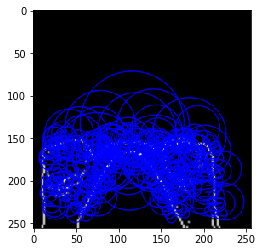

273


In [16]:
import numpy as np
import cv2
frame = cv2.imread('C:\\Users\\Subham\\Documents\\Indian-Sign-Language\\data\\images\\train\\a\\11.jpg')
frame = func(frame)

In [17]:
frame.shape

(273, 64)

In [18]:
frame

array([[  7.68245372e-05,  -3.16668411e-05,   7.68245372e-05, ...,
         -4.23315418e-04,   1.57867968e-02,   2.72028567e-03],
       [  1.26787636e-03,  -7.01281650e-04,   2.30354164e-03, ...,
          3.51960165e-03,   9.79576726e-03,   4.66532074e-03],
       [ -3.71267000e-04,  -1.47528308e-05,   3.71267000e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -6.34280615e-04,   1.20523516e-02,   1.31906606e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -3.87010310e-04,   7.27320649e-03,   8.01509619e-03],
       [ -1.00196860e-06,  -3.79913230e-03,   2.25765095e-03, ...,
         -2.10265876e-04,   2.61366609e-02,   9.41426679e-03]], dtype=float32)

In [19]:
img_descs=[]
img_descs.append(frame)

In [21]:
import numpy as np
import cv2
import os
import csv
import sklearn.metrics as sm
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
import random
import warnings
import pickle
from sklearn.naive_bayes import GaussianNB as nb
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression as lr
from sklearn.neural_network import MLPClassifier as mlp
import numpy as np
import sklearn.metrics as sm

C:\Users\Subham\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Subham\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [22]:
def train_test_val_split_idxs(total_rows, percent_test, percent_val):
    """
    Get indexes for training, test, and validation rows, given a total number of rows.
    Assumes indexes are sequential integers starting at 0: eg [0,1,2,3,...N]
    Returns:
    --------
    training_idxs, test_idxs, val_idxs
        Both lists of integers
    """
    if percent_test + percent_val >= 1.0:
        raise ValueError('percent_test and percent_val must sum to less than 1.0')

    row_range = range(total_rows)

    no_test_rows = int(total_rows*(percent_test))
    test_idxs = np.random.choice(row_range, size=no_test_rows, replace=False)
    # remove test indexes
    row_range = [idx for idx in row_range if idx not in test_idxs]

    no_val_rows = int(total_rows*(percent_val))
    val_idxs = np.random.choice(row_range, size=no_val_rows, replace=False)
    # remove validation indexes
    training_idxs = [idx for idx in row_range if idx not in val_idxs]

    print('Train-test-val split: %i training rows, %i test rows, %i validation rows' % (len(training_idxs), len(test_idxs), len(val_idxs)))

    return training_idxs, test_idxs, val_idxs

SyntaxError: 'return' outside function (<ipython-input-22-2210ab74879f>, line 27)

In [27]:
def cluster_features(img_descs, training_idxs, cluster_model):
    """
    Cluster the training features using the cluster_model
    and convert each set of descriptors in img_descs
    to a Visual Bag of Words histogram.
    Parameters:
    -----------
    X : list of lists of SIFT descriptors (img_descs)
    training_idxs : array/list of integers
        Indicies for the training rows in img_descs
    cluster_model : clustering model (eg KMeans from scikit-learn)
        The model used to cluster the SIFT features
    Returns:
    --------
    X, cluster_model :
        X has K feature columns, each column corresponding to a visual word
        cluster_model has been fit to the training set
    """
    n_clusters = cluster_model.n_clusters

    # # Generate the SIFT descriptor features
    # img_descs = gen_sift_features(labeled_img_paths)
    #
    # # Generate indexes of training rows
    # total_rows = len(img_descs)
    # training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(total_rows, percent_test, percent_val)

    # Concatenate all descriptors in the training set together
    training_descs = [img_descs[i] for i in training_idxs]
    all_train_descriptors = [desc for desc_list in training_descs for desc in desc_list]
    all_train_descriptors = np.array(all_train_descriptors)


    print ('%i descriptors before clustering' % all_train_descriptors.shape[0])

    # Cluster descriptors to get codebook
    print ('Using clustering model %s...' % repr(cluster_model))
    print ('Clustering on training set to get codebook of %i words' % n_clusters)

    # train kmeans or other cluster model on those descriptors selected above
    cluster_model.fit(all_train_descriptors)
    print ('done clustering. Using clustering model to generate BoW histograms for each image.')

    # compute set of cluster-reduced words for each image
    img_clustered_words = [cluster_model.predict(raw_words) for raw_words in img_descs]

    # finally make a histogram of clustered word counts for each image. These are the final features.
    img_bow_hist = np.array(
        [np.bincount(clustered_words, minlength=n_clusters) for clustered_words in img_clustered_words])

    X = img_bow_hist
    print ('done generating BoW histograms.')

    return X, cluster_model

In [28]:
def predict_knn(X_train, X_test, y_train, y_test):
    clf=knn(n_neighbors=3)
    print("knn started")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    calc_accuracy("K nearest neighbours",y_test,y_pred)
    np.savetxt('submission_surf_knn.csv', np.c_[range(1,len(y_test)+1),y_pred,y_test], delimiter=',', header = 'ImageId,Label,TrueLabel', comments = '', fmt='%d')
def calc_accuracy(method,label_test,pred):
    print("accuracy score for ",method,sm.accuracy_score(label_test,pred))
    print("precision_score for ",method,sm.precision_score(label_test,pred,average='micro'))
    print("f1 score for ",method,sm.f1_score(label_test,pred,average='micro'))
    print("recall score for ",method,sm.recall_score(label_test,pred,average='micro'))


In [29]:
y=[]
y.append(0)
y=np.array(y)
#training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(len(img_descs), 0.4, 0.0)

#creating histogram using kmeans minibatch cluster model
X, cluster_model = cluster_features(img_descs,[0], MiniBatchKMeans(n_clusters=150))

273 descriptors before clustering
Using clustering model MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=150, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)...
Clustering on training set to get codebook of 150 words
done clustering. Using clustering model to generate BoW histograms for each image.
done generating BoW histograms.


In [33]:
X.shape

(1, 150)

In [32]:
cluster_model

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=150, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

### Testing using SURF

In [38]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def func(frame):    
    frame = cv2.resize(frame,(128,128))
    converted2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     cv2.imshow("GRAY", frame)
#     cv2.waitKey(0)
    converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) # Convert from RGB to HSV
    #cv2.imshow("original",converted2)
#     cv2.imshow("HSV", converted)
#     cv2.waitKey(0)
    lowerBoundary = np.array([0,40,30],dtype="uint8")
    upperBoundary = np.array([43,255,254],dtype="uint8")
    skinMask = cv2.inRange(converted, lowerBoundary, upperBoundary)
    skinMask = cv2.addWeighted(skinMask,0.5,skinMask,0.5,0.0)
    #cv2.imshow("masked",skinMask)
#     cv2.imshow("masked",skinMask)
#     cv2.waitKey(0)
    skinMask = cv2.medianBlur(skinMask, 5)
    
    skin = cv2.bitwise_and(converted2, converted2, mask = skinMask)
    #frame = cv2.addWeighted(frame,1.5,skin,-0.5,0)
    #skin = cv2.bitwise_and(frame, frame, mask = skinMask)

    #skinGray=cv2.cvtColor(skin, cv2.COLOR_BGR2GRAY)
    
#     cv2.imshow("masked2",skin)
#     cv2.waitKey(0)
    img2 = cv2.Canny(skin,60,60)
#     cv2.imshow("edge detection",img2)
#     cv2.waitKey(0)
    #
    
    ''' 
    hog = cv2.HOGDescriptor()
    h = hog.compute(img2)
    print(len(h))
    
    '''
    surf = cv2.xfeatures2d.SURF_create()
    #surf.extended=True
    img2 = cv2.resize(img2,(256,256))
#     cv2.imshow("edge detection 256 ",img2)
#     cv2.waitKey(0)
    kp, des = surf.detectAndCompute(img2,None)
    #print(len(des))
    img2 = cv2.drawKeypoints(img2,kp,None,(0,0,255),4)
#     cv2.imshow("SURF Features ",img2)
#     cv2.waitKey(0)
#     plt.imshow(img2),plt.show()
    
#     cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(len(des))
    return des

def func2(path):    
    frame = cv2.imread(path)
    frame = cv2.resize(frame,(128,128))
    converted2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) # Convert from RGB to HSV
    #cv2.imshow("original",converted2)

    lowerBoundary = np.array([0,40,30],dtype="uint8")
    upperBoundary = np.array([43,255,254],dtype="uint8")
    skinMask = cv2.inRange(converted, lowerBoundary, upperBoundary)
    skinMask = cv2.addWeighted(skinMask,0.5,skinMask,0.5,0.0)
    #cv2.imshow("masked",skinMask)
    
    skinMask = cv2.medianBlur(skinMask, 5)
    
    skin = cv2.bitwise_and(converted2, converted2, mask = skinMask)
    
    #cv2.imshow("masked2",skin)
    img2 = cv2.Canny(skin,60,60)
    #cv2.imshow("edge detection",img2)
    img2 = cv2.resize(img2,(256,256))
    orb = cv2.xfeatures2d.ORB_create()
    kp, des = orb.detectAndCompute(img2,None)

    #print(len(des2))
    img2 = cv2.drawKeypoints(img2,kp,None,color=(0,255,0), flags=0)
    #plt.imshow(img2),plt.show()
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return des2

In [39]:
def vec_translate(a):
    my_dict = {'a':0,'b':1,'d':2,'e':3,'f':4,'g':5,'h':6,'j':7,'k':8,'m':9,
               'n':10,'o':11,'p':12,'q':13,'r':14,'s':15,'t':16,'x':17,'y':18,
               'z':19}
    return np.vectorize(my_dict.__getitem__)(a)

In [40]:
import numpy as np
import cv2
import os
import csv
import sklearn.metrics as sm
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
import random
import warnings
import pickle
from sklearn.naive_bayes import GaussianNB as nb
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression as lr
from sklearn.neural_network import MLPClassifier as mlp
import numpy as np
import sklearn.metrics as sm

from common.config import get_config
from common.image_transformation import apply_image_transformation
#initialise
label=0
img_descs=[]
y=[]

#utility functions
def perform_data_split(X, y, training_idxs, test_idxs, val_idxs):
    """
    Split X and y into train/test/val sets
    Parameters:
    -----------
    X : eg, use img_bow_hist
    y : corresponding labels for X
    training_idxs : list/array of integers used as indicies for training rows
    test_idxs : same
    val_idxs : same
    Returns:
    --------
    X_train, X_test, X_val, y_train, y_test, y_val
    """
    X_train = X[training_idxs]
    X_test = X[test_idxs]
    X_val = X[val_idxs]

    y_train = y[training_idxs]
    y_test = y[test_idxs]
    y_val = y[val_idxs]

    return X_train, X_test, X_val, y_train, y_test, y_val

def train_test_val_split_idxs(total_rows, percent_test, percent_val):
    """
    Get indexes for training, test, and validation rows, given a total number of rows.
    Assumes indexes are sequential integers starting at 0: eg [0,1,2,3,...N]
    Returns:
    --------
    training_idxs, test_idxs, val_idxs
        Both lists of integers
    """
    if percent_test + percent_val >= 1.0:
        raise ValueError('percent_test and percent_val must sum to less than 1.0')

    row_range = range(total_rows)

    no_test_rows = int(total_rows*(percent_test))
    test_idxs = np.random.choice(row_range, size=no_test_rows, replace=False)
    # remove test indexes
    row_range = [idx for idx in row_range if idx not in test_idxs]

    no_val_rows = int(total_rows*(percent_val))
    val_idxs = np.random.choice(row_range, size=no_val_rows, replace=False)
    # remove validation indexes
    training_idxs = [idx for idx in row_range if idx not in val_idxs]

    print('Train-test-val split: %i training rows, %i test rows, %i validation rows' % (len(training_idxs), len(test_idxs), len(val_idxs)))

    return training_idxs, test_idxs, val_idxs

def cluster_features(img_descs, training_idxs, cluster_model):
    """
    Cluster the training features using the cluster_model
    and convert each set of descriptors in img_descs
    to a Visual Bag of Words histogram.
    Parameters:
    -----------
    X : list of lists of SIFT descriptors (img_descs)
    training_idxs : array/list of integers
        Indicies for the training rows in img_descs
    cluster_model : clustering model (eg KMeans from scikit-learn)
        The model used to cluster the SIFT features
    Returns:
    --------
    X, cluster_model :
        X has K feature columns, each column corresponding to a visual word
        cluster_model has been fit to the training set
    """
    n_clusters = cluster_model.n_clusters

    # # Generate the SIFT descriptor features
    # img_descs = gen_sift_features(labeled_img_paths)
    #
    # # Generate indexes of training rows
    # total_rows = len(img_descs)
    # training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(total_rows, percent_test, percent_val)

    # Concatenate all descriptors in the training set together
    training_descs = [img_descs[i] for i in training_idxs]
    all_train_descriptors = [desc for desc_list in training_descs for desc in desc_list]
    all_train_descriptors = np.array(all_train_descriptors)


    print ('%i descriptors before clustering' % all_train_descriptors.shape[0])

    # Cluster descriptors to get codebook
    print ('Using clustering model %s...' % repr(cluster_model))
    print ('Clustering on training set to get codebook of %i words' % n_clusters)

    # train kmeans or other cluster model on those descriptors selected above
    cluster_model.fit(all_train_descriptors)
    print ('done clustering. Using clustering model to generate BoW histograms for each image.')

    # compute set of cluster-reduced words for each image
    img_clustered_words = [cluster_model.predict(raw_words) for raw_words in img_descs]

    # finally make a histogram of clustered word counts for each image. These are the final features.
    img_bow_hist = np.array(
        [np.bincount(clustered_words, minlength=n_clusters) for clustered_words in img_clustered_words])

    X = img_bow_hist
    print ('done generating BoW histograms.')

    return X, cluster_model

def calc_accuracy(method,label_test,pred):
    print("accuracy score for ",method,sm.accuracy_score(label_test,pred))
    print("precision_score for ",method,sm.precision_score(label_test,pred,average='micro'))
    print("f1 score for ",method,sm.f1_score(label_test,pred,average='micro'))
    print("recall score for ",method,sm.recall_score(label_test,pred,average='micro'))

def predict_svm(X_train, X_test, y_train, y_test):
    svc=SVC(kernel='linear') 
    print("svm started")
    svc.fit(X_train,y_train)
    y_pred=svc.predict(X_test)
    calc_accuracy("SVM",y_test,y_pred)
    np.savetxt('submission_surf_svm.csv', np.c_[range(1,len(y_test)+1),y_pred,y_test], delimiter=',', header = 'ImageId,Label,TrueLabel', comments = '', fmt='%d')
    

def predict_lr(X_train, X_test, y_train, y_test):
    clf = lr()
    print("lr started")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    calc_accuracy("Logistic regression",y_test,y_pred)
    np.savetxt('submission_surf_lr.csv', np.c_[range(1,len(y_test)+1),y_pred,y_test], delimiter=',', header = 'ImageId,Label,TrueLabel', comments = '', fmt='%d')
    


def predict_nb(X_train, X_test, y_train, y_test):
    clf = nb()
    print("nb started")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    calc_accuracy("Naive Bayes",y_test,y_pred)
    np.savetxt('submission_surf_nb.csv', np.c_[range(1,len(y_test)+1),y_pred,y_test], delimiter=',', header = 'ImageId,Label,TrueLabel', comments = '', fmt='%d')
    


def predict_knn(X_train, X_test, y_train, y_test):
    clf=knn(n_neighbors=3)
    print("knn started")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    calc_accuracy("K nearest neighbours",y_test,y_pred)
    np.savetxt('submission_surf_knn.csv', np.c_[range(1,len(y_test)+1),y_pred,y_test], delimiter=',', header = 'ImageId,Label,TrueLabel', comments = '', fmt='%d')
    

def predict_mlp(X_train, X_test, y_train, y_test):
    clf=mlp()
    print("mlp started")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    calc_accuracy("MLP classifier",y_test,y_pred)

training_images_labels_path = get_config('training_images_labels_path')
with open(training_images_labels_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    image_path, image_label = line.split()
    frame = cv2.imread(image_path)
    des=func(frame)
    img_descs.append(des)
    y.append(image_label)
y= vec_translate(y)
#finding indexes of test train and validate
y=np.array(y)
training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(len(img_descs), 0.4, 0.0)

#creating histogram using kmeans minibatch cluster model
X, cluster_model = cluster_features(img_descs, training_idxs, MiniBatchKMeans(n_clusters=150))

#splitting data into test, train, validate using the indexes
X_train, X_test, X_val, y_train, y_test, y_val = perform_data_split(X, y, training_idxs, test_idxs, val_idxs)


#using classification methods
predict_knn(X_train, X_test,y_train, y_test)
#predict_mlp(X_train, X_test,y_train, y_test)
predict_svm(X_train, X_test,y_train, y_test)

predict_lr(X_train, X_test,y_train, y_test)
predict_nb(X_train, X_test,y_train, y_test)


273
294
254
280
273
268
286
270
284
274
83
99
86
130
145
128
150
127
116
115
85
115
133
123
114
130
117
70
78
102
321
328
299
312
327
306
293
295
280
300
300
390
398
432
431
394
397
391
393
371
394
389
383
384
400
361
388
398
374
391
369
416
270
243
218
227
250
237
217
233
216
216
231
247
378
375
388
402
412
381
388
377
377
354
386
394
404
269
286
256
244
304
268
261
290
285
414
279
268
256
373
392
382
382
394
375
315
325
328
292
338
311
339
310
331
315
301
307
331
318
317
335
315
338
343
300
348
328
333
334
308
289
332
308
321
104
83
93
101
300
94
88
82
78
90
94
93
307
308
298
306
312
375
371
392
385
407
386
400
403
411
375
385
367
371
375
378
403
364
386
343
359
370
362
384
385
361
376
115
118
105
111
130
121
123
121
113
113
236
298
265
276
285
285
279
257
288
271
288
275
256
287
283
279
235
270
241
260
240
277
254
225
238
231
203
244
264
242
230
236
233
254
210
222
218
231
240
235
258
250
263
208
254
220
247
246
270
273
277
272
253
262
241
263
276
249
268
272
260
246
251
255
273
271

In [49]:
X_test.shape

(306, 150)

273
294
254
280
273
268
286
270
284
274
83
99
86
130
145
128
150
127
116
115
85
115
133
123
114
130
117
70
78
102
321
328
299
312
327
306
293
295
280
300
300
390
398
432
431
394
397
391
393
371
394
389
383
384
400
361
388
398
374
391
369
416
270
243
218
227
250
237
217
233
216
216
231
247
378
375
388
402
412
381
388
377
377
354
386
394
404
269
286
256
244
304
268
261
290
285
414
279
268
256
373
392
382
382
394
375
315
325
328
292
338
311
339
310
331
315
301
307
331
318
317
335
315
338
343
300
348
328
333
334
308
289
332
308
321
104
83
93
101
300
94
88
82
78
90
94
93
307
308
298
306
312
375
371
392
385
407
386
400
403
411
375
385
367
371
375
378
403
364
386
343
359
370
362
384
385
361
376
115
118
105
111
130
121
123
121
113
113
236
298
265
276
285
285
279
257
288
271
288
275
256
287
283
279
235
270
241
260
240
277
254
225
238
231
203
244
264
242
230
236
233
254
210
222
218
231
240
235
258
250
263
208
254
220
247
246
270
273
277
272
253
262
241
263
276
249
268
272
260
246
251
255
273
271

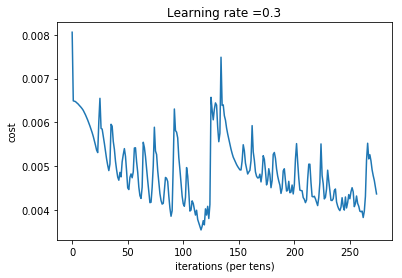

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.462039
Test Accuracy: 0.333333
Done!



In [50]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 20 02:26:11 2017

@author: Sanghai
"""
import sys

from common.config import get_config
import os
import sys
import csv
from sklearn.model_selection import train_test_split
import csv
import traceback

import numpy as np
import cv2

from common.config import get_config
from common.image_transformation import apply_image_transformation
from common.generate_images_labels import get_images_labels_list
from common.generate_images_labels import write_images_labels_to_file
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import cv2


    
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32,shape=(None,n_y))
    ### END CODE HERE ###
    
    return X, Y


def vec_translate(a):
    my_dict = {'a':0,'b':1,'d':2,'e':3,'f':4,'g':5,'h':6,'j':7,'k':8,'m':9,
               'n':10,'o':11,'p':12,'q':13,'r':14,'s':15,'t':16,'x':17,'y':18,
               'z':19}
    return np.vectorize(my_dict.__getitem__)(a)

def divide_data_train_test(images, labels, ratio):
    print("\nDividing dataset in the ratio '{}' using `train_test_split()`:".format(ratio))
    ret = train_test_split(images, labels, test_size=ratio, random_state=0)
    print("Done!\n")
    return ret

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1",[4,4,1,8],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    print(W1)
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 20, activation_fn=None)
    ### END CODE HERE ###

    return Z3

# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END CODE HERE ###
    
    return cost

# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.3,
          num_epochs = 275, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3
    X_train = np.reshape(X_train,[-1,150,1,1])
    X_test = np.reshape(X_test,[-1,150,1,1])                                      # to keep results consistent (numpy seed)
    (m, n_H0, n_W0,n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X,parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.MomentumOptimizer(0.3,0.5).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            #print(type(X_train))
            #print(type(Y_train))
            #num_minibatches = int(int(m) / int(minibatch_size)) # number of minibatches of size minibatch_size in the train set
            #seed = seed + 1
            #minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            #for minibatch in minibatches:

                # Select a minibatch
                #(minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
            _ , temp_cost = sess.run([optimizer,cost],feed_dict={X: X_train, Y: Y_train})
                ### END CODE HERE ###
                
            minibatch_cost += temp_cost / X_train.shape[0]
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters
    

def read_images_transformed(images_transformed_path):
    print("\nReading the transformed images file located at path '{}'...".format(
        images_transformed_path))

    images = []
    labels = []
    with open(images_transformed_path) as images_transformed_file:
        reader = csv.reader(images_transformed_file, delimiter=',')
        cnt = 0
        for line in reader:
            if len(line)==0:
                continue
            cnt = cnt + 1
            label = line[0]
            labels.append(label)
            image = line[1:]
            image_int = [int(pixel) for pixel in image]
            image = np.array(image_int)
            images.append(image)
    print("Done!\n")
    return images, labels

def main():
        label=0
        img_descs=[]
        y=[]
        training_images_labels_path = get_config('training_images_labels_path')
        with open(training_images_labels_path, 'r') as file:
            lines = file.readlines()

        for line in lines:
            image_path, image_label = line.split()
            frame = cv2.imread(image_path)
            des=func(frame)
            img_descs.append(des)
            y.append(image_label)
        y= vec_translate(y)
        #finding indexes of test train and validate
        y=np.array(y)
        training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(len(img_descs), 0.4, 0.0)

        #creating histogram using kmeans minibatch cluster model
        X, cluster_model = cluster_features(img_descs, training_idxs, MiniBatchKMeans(n_clusters=150))

        #splitting data into test, train, validate using the indexes
        X_train, X_test, X_val, y_train, y_test, y_val = perform_data_split(X, y, training_idxs, test_idxs, val_idxs)
        y_train = convert_to_one_hot(y_train, 20).T
        y_test = convert_to_one_hot(y_test, 20).T
        #print(X_train.shape)
        _, _, parameters = model(X_train, y_train, X_test, y_test)
        print("Done!\n")


if __name__ == '__main__':
    main()
